# Limpieza de datos del pronóstico

## Bibliotecas y parámetros

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import median_absolute_deviation as mad

In [2]:
plt.rcParams['figure.figsize'] = [16, 4]

## Funciones auxiliares

In [3]:
def detect_outliers(ds, window=5, alpha=3):
    scaling_constant = 1.4826
    rolling_median = ds.rolling(window, center=True).median()
    rolling_deviations = scaling_constant * ds.rolling(window, center=True).apply(mad, raw=False)
    threshold = rolling_deviations.mean()
    spikes = (ds - rolling_median).abs() > alpha*threshold
    return spikes

## Carga de datos

In [4]:
# Cargamos los datos
data = pd.read_excel("../data/clima_abril_sept_orig.xlsx", sheet_name="Hoja2")
data.head(10)

,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
0,01/04/2019,23Z,19.3,86%,1013.2 Hpa,20º (N),11.2,2/8,-,1/8 AC,CI,-,-,-,Algunas nubes
1,01/04/2019,22Z,21.0,77%,1013.0 Hpa,20º (N),13.0,3/8,-,2/8 AC,CI,-,-,-,Nubes dispersas
2,01/04/2019,21Z,25.2,58%,1013.5 Hpa,360º (N),14.8,5/8,-,4/8 AC,CI,-,-,-,Nuboso
3,01/04/2019,20Z,27.0,48%,1013.4 Hpa,360º (N),18.4,5/8,-,4/8 AC,CI,-,-,-,Nuboso
4,01/04/2019,19Z,26.6,47%,1013.5 Hpa,20º (N),18.4,4/8,-,4/8 AC,-,-,-,-,Nubes dispersas
5,01/04/2019,18Z,27.2,40%,1013.8 Hpa,360º (N),20.5,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
6,01/04/2019,17Z,27.0,45%,1014.6 Hpa,360º (N),22.3,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
7,01/04/2019,16Z,26.2,47%,1015.6 Hpa,360º (N),18.4,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
8,01/04/2019,15Z,24.7,50%,1016.0 Hpa,360º (N),14.8,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
9,01/04/2019,14Z,22.8,56%,1016.5 Hpa,360º (N),16.6,1/8,-,1/8 AC,-,-,-,-,Algunas nubes


### Indice y nombre de columna

Combinamos las columnas de fecha y hora para crear un indice en formato datetime y acomodamos los nombres de las columnas para acceso más conveniente.

In [5]:
data["Hora UTC"] = data["Hora UTC"].map(lambda x: x[:-1])
data["fecha"] = pd.to_datetime(data["Fecha"] + " " + data["Hora UTC"], format="%d/%m/%Y %H")
data = data.set_index("fecha").sort_index()
data = data.drop(labels=["Hora UTC", "Fecha"], axis=1)
data.columns = ["temp", "hum", "presion", "dir", "vel", 
                "nub", "n_bajas", "n_medias", "n_altas", "prec", 
                "t_max", "t_min", "situacion"]
data.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85%,1016.3 Hpa,070º (E ),14.8,6/8,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93%,1016.7 Hpa,70º (E),9.4,4/8,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95%,1016.7 Hpa,70º (E),3.6,0/8,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96%,1016.7 Hpa,180º (S),5.4,0/8,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95%,1016.3 Hpa,110º (E),7.6,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


### Tiramos columnas

In [6]:
data = data.drop(columns=["n_bajas", "n_medias", "n_altas", "prec", "t_max", "t_min"])

### Valores faltantes iniciales

In [7]:
data.isna().sum()

temp          4
hum           6
presion       0
dir           0
vel          10
nub           0
situacion     0
dtype: int64

### Variables categóricas y numéricas

Las distinguimos para más fácil acceso.

In [8]:
numerical = ["temp", "hum", "presion", "vel"]
categorical = ["nub", "dir"]

## Limpieza

Nos quedamos con la información que nos interesa de cada columna. También nos fijamos qué observaciones siguen un patrón diferente y vemos si las descartamos o podemos arreglarlas.

### Humedad

In [9]:
# Observaciones donde la columna humedad no sigue el formato esperado.
mask = ~data.hum.str.match("^\d{,3}\%$", na=False)
data[mask]

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-05-26 15:00:00,10.2,NaN,1011.2 Hpa,320º (NW),9.3,8/8,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5 Hpa,calma,NaN,5/8,"Nuboso, niebla"
2019-06-22 12:00:00,7.8,NaN,1019.3 Hpa,230º (SW),7.4,6/8,"Nuboso, neblina"
2019-06-27 23:00:00,4.1,NaN,1010.5 Hpa,360º (N ),9.3,8/8,Cubierto
2019-07-09 17:00:00,4.6,NaN,1020.9 Hpa,320º (NW),5.6,4/8,Nubes dispersas
2019-08-06 07:00:00,3.4,NaN,1013.8 Hpa,340º (N ),11.1,0/8,Despejado


La columna de humedad no tiene problemas, solo datos faltantes, así que la transformamos a numérico.

In [10]:
data.hum = pd.to_numeric(data.hum.str.strip("%"))
data.head()

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3 Hpa,070º (E ),14.8,6/8,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7 Hpa,70º (E),9.4,4/8,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7 Hpa,70º (E),3.6,0/8,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7 Hpa,180º (S),5.4,0/8,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3 Hpa,110º (E),7.6,4/8,"Nubes dispersas, neblina"


### Presión

In [11]:
# Observaciones donde la presión no sigue el patrón que debería
mask = ~data.presion.str.match("^\s*\d{3,4}[.]\d\s*Hpa\s*$", na=False)
data[mask]

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-06-23 00:00:00,17.6,62.0,-,320º (NW),3.7,7/8,"Nuboso, neblina"
2019-06-28 10:00:00,4.4,89.0,-,180º (S),9.4,6/8,Nuboso
2019-07-16 01:00:00,2.8,86.0,234 m (1000 Hpa),200º (S),5.4,0/8,Despejado
2019-07-25 13:00:00,3.0,62.0,-,110º (E ),7.4,7/8,Nuboso
2019-09-03 05:00:00,23.7,17.0,-,230º (SW),18.5,0/8,Despejado


Tenemos un valor con un formato diferente al resto y datos faltantes. Solo nos interesa el valor numérico, así que lo extraemos y asignamos NA a las observaciones problemáticas.

In [12]:
ext = data.presion.str.extract("^\s*(\d{3,4}[.]\d)\s*Hpa\s*$") # Extrae y asigna NA a las que no coinciden con el patrón.
data.presion = pd.to_numeric(ext[0])
data.head()

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,070º (E ),14.8,6/8,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,70º (E),9.4,4/8,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,70º (E),3.6,0/8,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,180º (S),5.4,0/8,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,110º (E),7.6,4/8,"Nubes dispersas, neblina"


### Dirección del viento

In [13]:
# Observaciones de dirección con formato diferente al esperado.
mask = ~data.dir.str.match("^\s*\d{1,3}.\s*[(]\s*[NESW]{,2}\s*[)]\s*$", na=False)
data[mask]

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-04-01 06:00:00,15.6,96.0,1015.8,calma,NaN,5/8,"Nuboso, neblina"
2019-06-01 06:00:00,7.1,93.0,1016.8,calma,NaN,8/8,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5,calma,NaN,5/8,"Nuboso, niebla"
2019-06-22 00:00:00,9.9,93.0,1019.5,calma,NaN,7/8,Nuboso
2019-07-07 12:00:00,-0.4,95.0,1026.9,calma,NaN,5/8,Nuboso
2019-07-31 09:00:00,3.9,100.0,1010.3,calma,NaN,2/8,"Algunas nubes, niebla"
2019-08-10 12:00:00,-0.4,95.0,1017.1,calma,NaN,0/8,Despejado
2019-08-22 12:00:00,4.8,93.0,1030.6,calma,NaN,8/8,Cubierto
2019-08-26 12:00:00,9.4,93.0,1018.7,calma,NaN,0/8,"Despejado, niebla"


Nos quedamos solo con el punto cardinal y le asignamos "-" a la dirección en aquellas observaciones que corresponden a días sin viento, como también cero a la velocidad.

In [14]:
ext = data.dir.str.extract("^\s*\d{1,3}.\s*[(]\s*([NESW]{,2})\s*[)]\s*$")
data.loc[data.dir != "calma", "dir"] = ext[0]
data.loc[data.dir == "calma", ["dir", "vel"]] = ["-", 0]

Comprobamos si los días con velocidad cero coinciden con aquellos días con dirección nula.

In [15]:
(data.vel == 0).equals(data.dir == "-")

False

No coinciden, así que lo revisamos mejor.

In [16]:
data[(data.vel == 0) != (data.dir == "-")].head(10)

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-04-01 05:00:00,16.0,96.0,1016.6,N,0.0,4/8,"Nubes dispersas, neblina"
2019-04-02 02:00:00,17.2,93.0,1012.8,N,0.0,0/8,Despejado
2019-04-03 05:00:00,9.0,96.0,1014.8,N,0.0,0/8,Despejado
2019-04-04 00:00:00,12.9,73.0,1007.1,N,0.0,0/8,Despejado
2019-04-05 21:00:00,18.2,47.0,1020.2,N,0.0,0/8,Despejado
2019-04-05 22:00:00,14.1,67.0,1020.7,N,0.0,0/8,Despejado
2019-04-06 00:00:00,8.6,87.0,1021.6,N,0.0,0/8,Despejado
2019-04-06 01:00:00,7.7,87.0,1022.1,N,0.0,0/8,Despejado
2019-04-06 02:00:00,6.6,88.0,1022.2,N,0.0,0/8,Despejado


Parece que en casi todos los días con velocidad cero la dirección asignada fue N(0°).

In [17]:
data[data.vel == 0].dir.unique()

array(['N', '-'], dtype=object)

En efecto, ese es el caso, por lo que procedemos a reemplazar todos esos N con "-".

In [18]:
data.loc[data.vel == 0, "dir"] = "-"

### Nubosidad

In [19]:
data.nub.unique()

array(['6/8 ', '4/8', '0/8', '5/8 ', '7/8', '6/8', '3/8', '5/8', '1/8',
       '2/8', '2/8 ', 'N/D', '8/8', '8/8 ', '0/8 ', '7/8 ', '3/8 ',
       '1/8 ', '4/8 ', 'N/D '], dtype=object)

Hay algunos espacios al final que hay que limpiar.

In [20]:
data.nub = data.nub.str.strip()

Revisamos los valores "N/D".

In [21]:
data[data.nub == "N/D"].head()

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-04-02 10:00:00,17.9,98.0,1010.7,NW,11.2,N/D,Niebla
2019-04-02 11:00:00,17.6,100.0,1010.9,NW,11.2,N/D,Niebla
2019-04-02 12:00:00,18.0,100.0,1010.6,N,11.2,N/D,Niebla
2019-04-02 13:00:00,19.6,100.0,1010.6,NW,13.0,N/D,Niebla
2019-04-04 08:00:00,11.9,100.0,1001.0,N,3.6,N/D,Niebla


In [22]:
data.loc[data.nub == "N/D", "situacion"].unique()

array(['Niebla', 'niebla'], dtype=object)

Corresponden a días con niebla. Vamos a asignarles un valor de 9, bajo la interpretación de que la niebla representa más nubosidad que un día completamente cubierto, y vamos a quedarnos con el numerador del resto de observaciones; luego convertimos a numérico.

In [23]:
data.nub = data.nub.apply(lambda x: x[0])
data.loc[data.nub == "N", "nub"] = "9"
#data.nub = pd.to_numeric(data.nub)

In [24]:
data.nub.unique()

array(['6', '4', '0', '5', '7', '3', '1', '2', '9', '8'], dtype=object)

## Datos faltantes y outliers

In [25]:
data.isna().sum()

temp         4
hum          6
presion      5
dir          0
vel          0
nub          0
situacion    0
dtype: int64

Revisamos los valores faltantes de temperatura.

In [26]:
data[data.temp.isna()]

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-06-22 21:00:00,NaN,0.0,1017.4,N,57.4,1,Algunas nubes
2019-06-23 10:00:00,NaN,0.0,1012.4,N,122.3,1,Algunas nubes
2019-07-26 21:00:00,NaN,0.0,1020.8,S,11.1,5,Nuboso
2019-08-30 00:00:00,NaN,0.0,1015.9,N,113.0,1,Algunas nubes


Esas observaciones tienen valores nulos en la columna de humedad. Nos fijamos si las observaciones con humedad 0 son las mismas.

In [27]:
data[data.temp.isna()].equals(data[data.hum == 0])

True

Claramente los valores de humedad cero en realidad corresponden a mediciones faltantes, así que los representamos como tal.

In [28]:
data.loc[data.hum == 0, "hum"] = np.nan

Ahora revisamos los datos faltantes en la columna de humedad.

In [29]:
data[data.hum.isna()]

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-05-26 15:00:00,10.2,NaN,1011.2,NW,9.3,8,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5,-,0.0,5,"Nuboso, niebla"
2019-06-22 12:00:00,7.8,NaN,1019.3,SW,7.4,6,"Nuboso, neblina"
2019-06-22 21:00:00,NaN,NaN,1017.4,N,57.4,1,Algunas nubes
2019-06-23 10:00:00,NaN,NaN,1012.4,N,122.3,1,Algunas nubes
2019-06-27 23:00:00,4.1,NaN,1010.5,N,9.3,8,Cubierto
2019-07-09 17:00:00,4.6,NaN,1020.9,NW,5.6,4,Nubes dispersas
2019-07-26 21:00:00,NaN,NaN,1020.8,S,11.1,5,Nuboso
2019-08-06 07:00:00,3.4,NaN,1013.8,N,11.1,0,Despejado


Y los de la columna de presión.

In [30]:
data[data.presion.isna()]

,temp,hum,presion,dir,vel,nub,situacion
fecha,,,,,,,
2019-06-23 00:00:00,17.6,62.0,NaN,NW,3.7,7,"Nuboso, neblina"
2019-06-28 10:00:00,4.4,89.0,NaN,S,9.4,6,Nuboso
2019-07-16 01:00:00,2.8,86.0,NaN,S,5.4,0,Despejado
2019-07-25 13:00:00,3.0,62.0,NaN,E,7.4,7,Nuboso
2019-09-03 05:00:00,23.7,17.0,NaN,SW,18.5,0,Despejado


Revisamos si hay fechas faltantes.

In [31]:
start = data.index[0]
end = data.index[-1]
missing_dates = pd.date_range(start=start, end=end, freq="H").difference(data.index)
print("Hay {} valores faltantes en las observaciones.".format(len(missing_dates)))
print("Los días y horas que faltan son:")
missing_dates

Hay 73 valores faltantes en las observaciones.
Los días y horas que faltan son:


DatetimeIndex(['2019-04-02 04:00:00', '2019-04-25 07:00:00',
               '2019-05-22 07:00:00', '2019-05-23 02:00:00',
               '2019-05-23 04:00:00', '2019-05-23 08:00:00',
               '2019-05-27 17:00:00', '2019-06-13 13:00:00',
               '2019-06-16 07:00:00', '2019-06-16 10:00:00',
               '2019-06-16 11:00:00', '2019-06-16 12:00:00',
               '2019-06-16 13:00:00', '2019-06-16 14:00:00',
               '2019-06-16 15:00:00', '2019-06-16 16:00:00',
               '2019-06-16 17:00:00', '2019-06-16 18:00:00',
               '2019-06-16 19:00:00', '2019-06-16 20:00:00',
               '2019-06-16 21:00:00', '2019-06-16 22:00:00',
               '2019-06-16 23:00:00', '2019-06-17 00:00:00',
               '2019-06-17 01:00:00', '2019-06-17 02:00:00',
               '2019-06-17 03:00:00', '2019-06-17 04:00:00',
               '2019-06-17 05:00:00', '2019-06-17 06:00:00',
               '2019-06-17 07:00:00', '2019-06-17 08:00:00',
               '2019-06-

Le decimos a pandas que ponga los datos en frecuencia horaria, creando NA para los valores que faltan.

In [32]:
data = data.asfreq("H")
data.isna().sum()

temp         77
hum          83
presion      78
dir          73
vel          73
nub          73
situacion    73
dtype: int64

Vemos como se distribuyen las fechas faltantes.

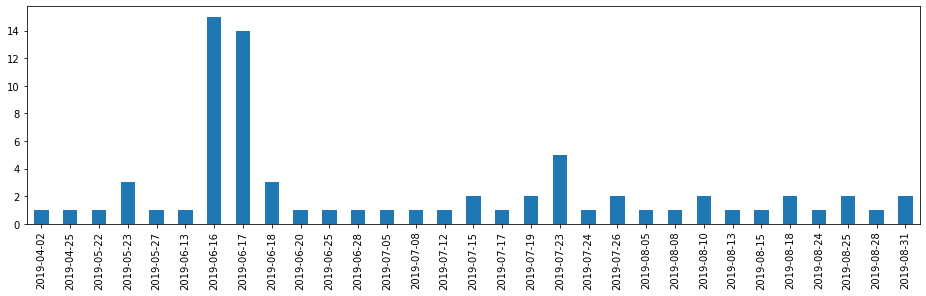

In [33]:
ds = data.loc[data.index.isin(missing_dates)].reset_index().fecha.dt.date.value_counts().sort_index()
ds.plot(kind="bar");

Los días 2019-06-16 y 2019-06-17 son los que registran un mayor número de valores faltantes. Si graficamos algunas de las series temporales...

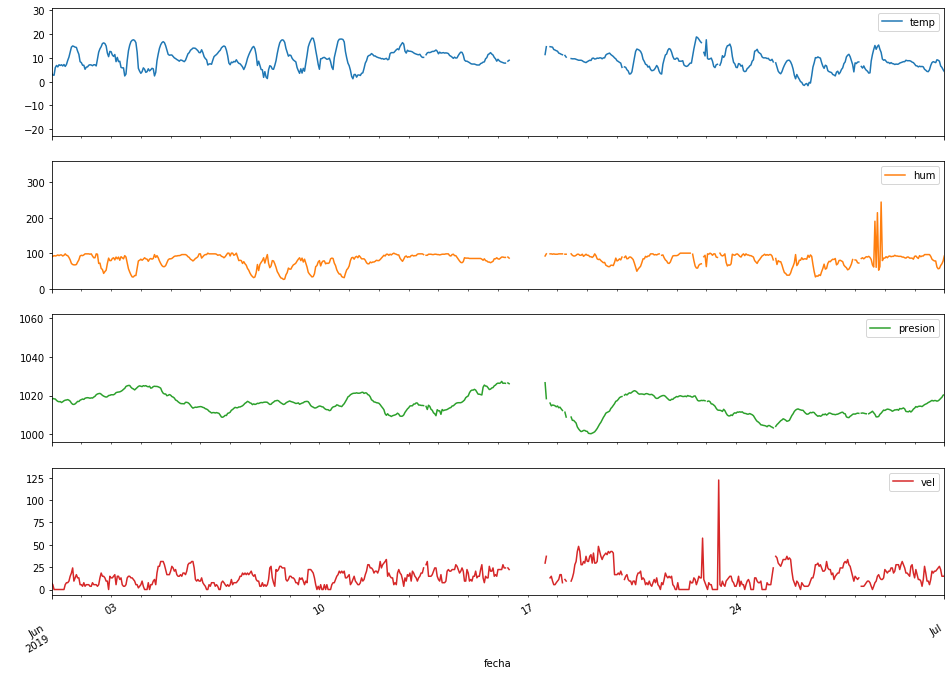

In [34]:
data.plot(subplots=True, layout=(4,1), y=numerical, figsize=(16, 12), xlim=("2019-06", "2019-07"));

...queda claro que esos valores faltantes son consecutivos. También parece que el intervalo entre el día 11 y 20 de junio presenta un patrón diferente al resto del mes. Específicamente, las oscilaciones diarias de temperatura y humedad disminuyen notablemente. Eso es extraño, y sumado a la gran cantidad de observaciones faltantes, podría indicar un problema con las mediciones de ese período.

Vamos a revisar las series completas.

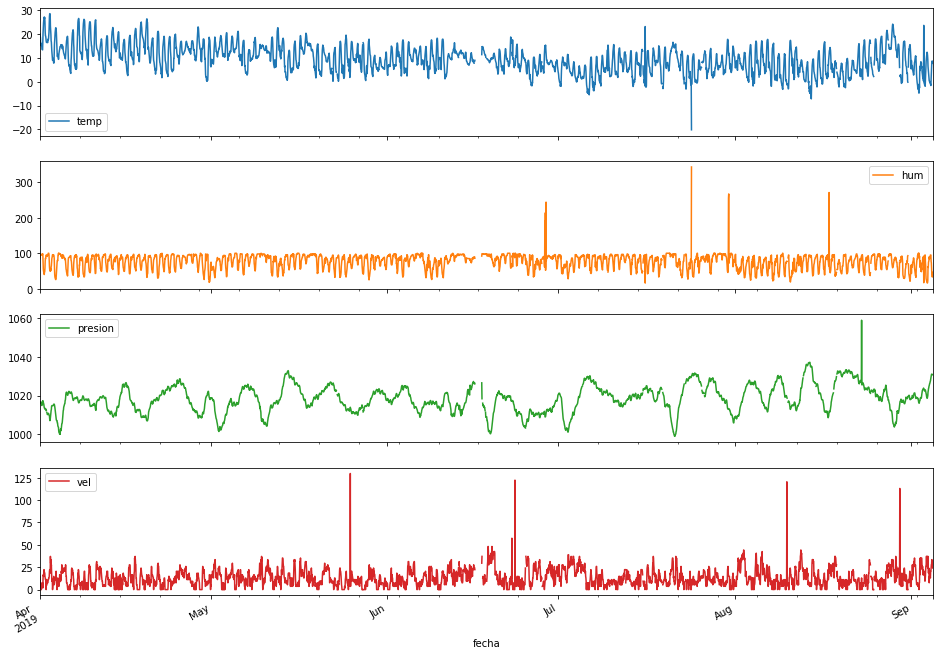

In [35]:
data.plot(subplots=True, layout=(4,1), y=numerical, figsize=(16, 12));

Efectivamente, las series de temperatura y humedad no parecen confiables durante el intervalo del 11 al 20 de junio, por lo que descartamos esas observaciones. 

In [36]:
data.loc["2019-06-11":"2019-06-20", ["temp", "hum"]] = np.nan

Interpolamos las series para completar los datos faltantes.

In [37]:
data.loc[:, numerical] = data.loc[:, numerical].interpolate(limit=5)

También se observa la presencia de picos en las series, así que vamos a aplicar un filtro para detectarlos, marcarlos como NA.  Luego los rellenamos.

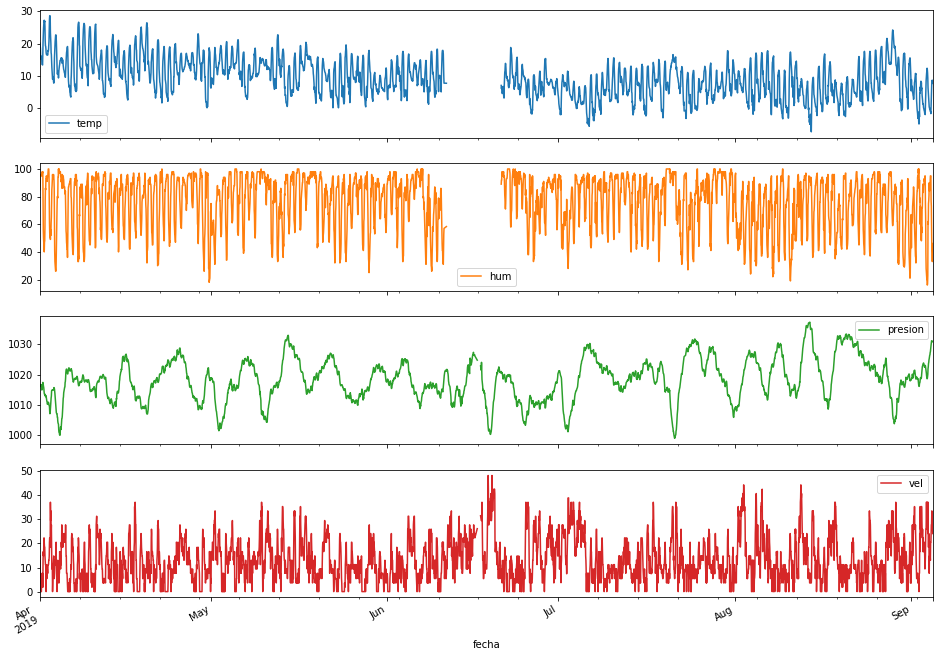

In [38]:
spikes = data.loc[:, numerical].apply(detect_outliers)
data.loc[:, numerical] = data.loc[:, numerical].mask(spikes).interpolate(limit=5)
data.loc[:, numerical].plot(subplots=True, layout=(4,1), figsize=(16, 12));

#### Datos faltantes al final del proceso

In [39]:
data.isna().sum()

temp         230
hum          230
presion       13
dir           73
vel           13
nub           73
situacion     73
dtype: int64

## Guardamos la tabla

In [40]:
data.to_csv("../data/clima_abril_sept.csv")

# Limpieza de datos de potencia

## Carga de datos

In [41]:
potencia = pd.read_excel("../data/potencia_orig.xlsx")
potencia.head(10)

,fecha,hora,potencia
0,2019-05-30,12:46:35.405,1003
1,2019-05-30,12:47:35.602,1007
2,2019-05-30,12:45:35.014,975
3,2019-05-30,12:48:35.953,989
4,2019-05-30,12:49:36.036,800
5,2019-05-30,12:50:36.213,786
6,2019-05-30,12:51:36.429,875
7,2019-05-30,12:52:36.632,860
8,2019-05-30,12:53:36.958,792
9,2019-05-30,12:54:37.204,785


## Limpieza

### Indice

No todos los datos de hora fueron procesados por pandas debido a que no se encuentra toda la columna en el mismo formato. Nos conviene pasar todo a texto y acomodar los datos manualmente.

Buscamos todos las horas que están en formato texto.

In [42]:
str_times = potencia.hora.apply(lambda x: type(x) == str)

Todas las que no están como texto las volvemos a convertir a texto.

In [43]:
potencia.loc[~str_times, "hora"] = potencia.loc[~str_times, "hora"].apply(lambda x: x.strftime("%H:%M"))

Extraemos solo las horas y los minutos, el resto no nos interesa.

In [44]:
potencia.hora = potencia.hora.str.extract("^(\d{,2}:\d{,2}).*$")[0]

Convertimos la columna de fecha a texto y la combinamos con la de hora para luego transformarla a datetime.

In [45]:
potencia.fecha = potencia.fecha.apply(lambda x: x.strftime("%Y-%m-%d"))
potencia.fecha = pd.to_datetime(potencia.fecha + " " + potencia.hora, format="%Y-%m-%d %H:%M")

Tiramos la columna hora.

In [46]:
potencia = potencia.drop(columns="hora")

Ordenamos e indexamos.

In [47]:
potencia = potencia.sort_values("fecha").set_index("fecha")

potencia.head()

,potencia
fecha,
2019-05-30 12:45:00,975
2019-05-30 12:46:00,1003
2019-05-30 12:47:00,1007
2019-05-30 12:48:00,989
2019-05-30 12:49:00,800


## Guardamos la tabla

In [48]:
potencia.to_csv("../data/potencia.csv")

## Visualización

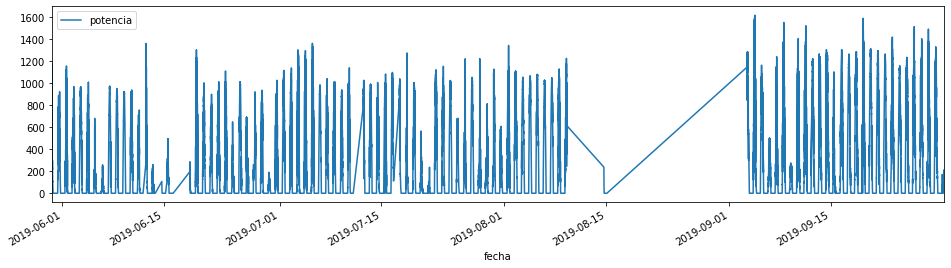

In [49]:
potencia.plot();

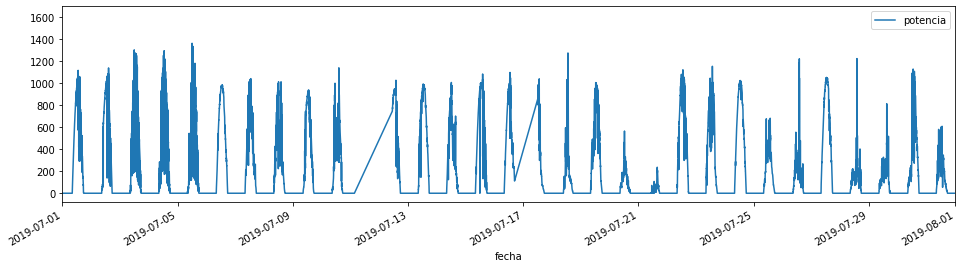

In [50]:
potencia.plot(xlim=("2019-07-01", "2019-08-01"));

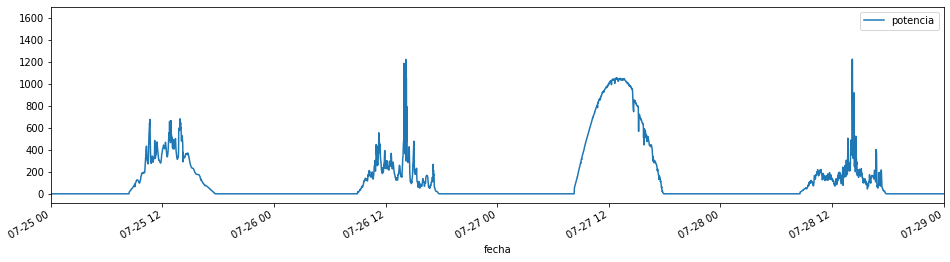

In [51]:
potencia.plot(xlim=("2019-07-25", "2019-07-29"));

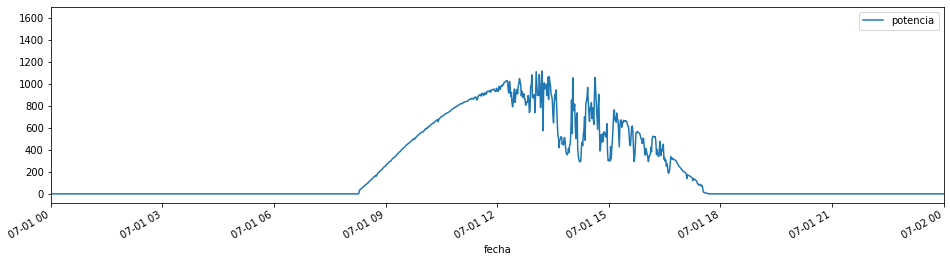

In [52]:
potencia.plot(xlim=("2019-07-01", "2019-07-02"));

# Unión de datos del clima y de potencia

## Resampling potencia

Text(0, 0.5, 'Potencia (W)')

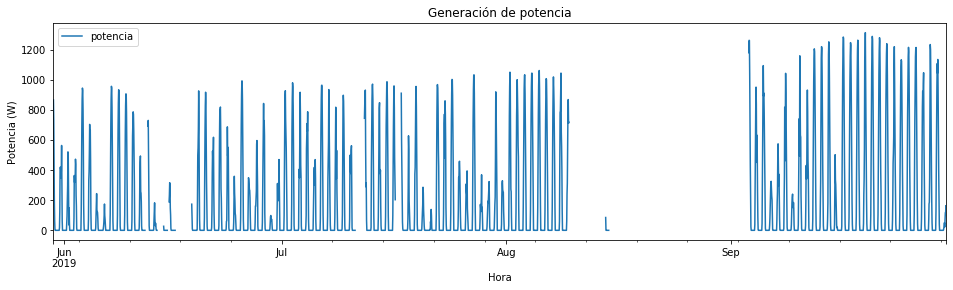

In [66]:
potencia = potencia.resample("H").mean()
potencia.plot()
plt.title("Generación de potencia")
plt.xlabel("Hora")
plt.ylabel("Potencia (W)")

## Merge

In [54]:
data = pd.merge(potencia, data, left_index=True, right_index=True)
data = data.asfreq("H")

## Visualización

In [55]:
numerical = ["potencia", "temp", "hum", "presion", "vel"]
categorical = ["nub", "dir"]

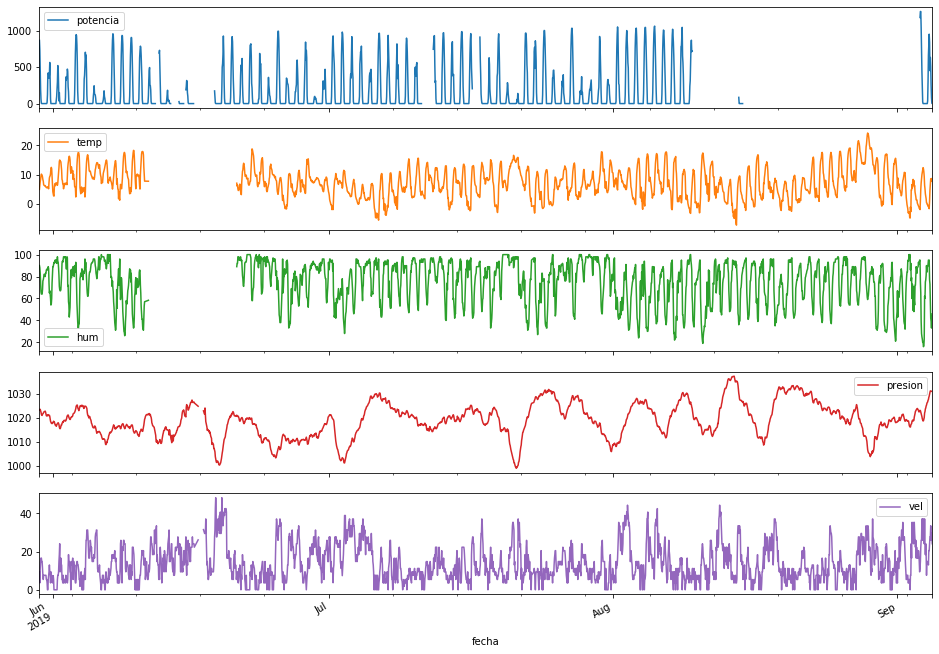

In [56]:
data.plot(y=numerical, subplots=True, layout=(len(numerical), 1), figsize=(16, 12));

## Guardamos

In [57]:
data.to_csv("../data/tabla_generacion_energia.csv")